![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [16]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [17]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [18]:
# Celda 1

#Importar librerias
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Definición de la función que calcula el MSE
def mse(y):
    if len(y) == 0:
        return 0
    return np.mean((y - y.mean())**2)

# Definición de la función MSE_gain para calular la ganancia
def mse_gain(X_col, y, split):
    left_mask = X_col < split
    y_left = y[left_mask]
    y_right = y[~left_mask]

    if len(y_left) == 0 or len(y_right) == 0:
        return 0

    mse_parent = mse(y)
    mse_left = mse(y_left)
    mse_right = mse(y_right)

    n = len(y)
    gain = mse_parent - (len(y_left)/n)*mse_left - (len(y_right)/n)*mse_right
    return gain

# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    features = range(X.shape[1])
    best_split = {'feature': None, 'split': None, 'gain': -np.inf}

    # Para todas las varibles
    for j in features:
        X_col = X.iloc[:, j]
        # Columna booleana
        if X_col.dtypes == 'bool':
            splits = [0.5]  # Split booleanos en 0.5
        # Otra columna
        else:
            splits = np.unique(np.percentile(X_col, np.linspace(0, 100, num_pct + 2)))[1:-1]

        # Para cada partición
        for split in splits:
            gain = mse_gain(X_col, y, split)

            if gain > best_split['gain']:
                best_split.update({'feature': j, 'split': split, 'gain': gain})
    return best_split

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree

    # Calcular la mejor división
    split_info = best_split(X, y, num_pct)

    # Revisar el criterio de parada
    if split_info['gain'] < min_gain:
        return {'y_pred': y.mean(), 'split': -1, 'level': level, 'n_samples': len(y)}

    # Continuar creando la partición
    j, split = split_info['feature'], split_info['split']
    left_mask = X.iloc[:, j] < split

    # Siguiente iteración para cada partición
    X_left, y_left = X[left_mask], y[left_mask]
    X_right, y_right = X[~left_mask], y[~left_mask]

    return {
        'split': [j, split],
        'level': level,
        'n_samples': len(y),
        'y_pred': y.mean(),
        'sl': tree_grow(X_left, y_left, level+1, min_gain, max_depth, num_pct),
        'sr': tree_grow(X_right, y_right, level+1, min_gain, max_depth, num_pct)
    }


# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'
def tree_predict(X, tree):
    preds = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        node = tree
        while node['split'] != -1:
            j, split = node['split']
            if X.iloc[i, j] < split:
                node = node['sl']
            else:
                node = node['sr']
        preds[i] = node['y_pred']
    return preds


In [19]:
# Entrenar árbol
tree = tree_grow(X_train, y_train, max_depth=3)

# Predicción y métricas
y_pred = tree_predict(X_test, tree)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE en test: {rmse:.2f}")
print(f"MAE en test: {mae:.2f}")

RMSE en test: 2137.95
MAE en test: 1599.61


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [20]:
# Celda 2
# Se crea un arreglo de 1 a 20
np.random.seed(1)

# Impresión de arreglo y muestreo aleatorio
nums = np.arange(1, 21)
print('Arreglo:', nums)
print('Muestreo aleatorio: ', np.random.choice(a=nums, size=20, replace=True))

# Creación de 10 muestras de bootstrap
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

# Visualización muestra boostrap #1 para entremiento
X_train.iloc[samples[0], :]




Arreglo: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Muestreo aleatorio:  [ 6 12 13  9 10 12  6 16  1 17  2 13  8 14  7 19  6 19 12 11]


,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
151599,2016,40999,False,False,False,False,False,True,False
171999,2014,52527,False,False,False,False,False,True,False
304172,2009,123202,False,True,False,False,False,False,False
74828,2015,38807,False,False,False,False,False,True,False
192974,2005,51260,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...
134843,2014,22221,False,False,False,False,True,False,False
325075,2013,86593,False,False,False,False,False,True,False
61213,2014,28044,False,False,False,False,False,True,False
181222,2016,49368,False,False,False,False,False,False,True


In [21]:
 # Construcción un árbol de decisión para cada muestra boostrap

from sklearn.tree import DecisionTreeRegressor


# Definición del modelo usando DecisionTreeRegressor de sklearn
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_train_b = X_train.iloc[sample]
    y_train_b = y_train.iloc[sample]
    treereg.fit(X_train_b, y_train_b)
    y_pred.iloc[:,i] = treereg.predict(X_test)

y_pred

,0,1,2,3,4,5,6,7,8,9
257343,14980.0,13993.0,13649.0,13649.0,11788.0,13649.0,13993.0,13990.0,13990.0,13993.0
326011,6492.0,5995.0,5995.0,6987.0,5995.0,5995.0,5995.0,6987.0,5995.0,5995.0
242354,16491.0,16995.0,16491.0,15997.0,15997.0,16491.0,17591.0,16995.0,17404.0,16491.0
266376,21990.0,21990.0,22500.0,21990.0,15900.0,21990.0,22500.0,21990.0,15813.0,21990.0
396954,15988.0,16951.0,15988.0,15988.0,15988.0,17900.0,16951.0,16951.0,15988.0,15988.0
...,...,...,...,...,...,...,...,...,...,...
144298,13836.0,14800.0,14800.0,14800.0,14800.0,14681.0,14800.0,14800.0,13836.0,13836.0
364521,15999.0,14995.0,15999.0,16900.0,15999.0,15999.0,17300.0,15999.0,16900.0,15000.0
120072,23533.0,23533.0,20000.0,17700.0,17700.0,23533.0,17700.0,23533.0,23533.0,20000.0
99878,12989.0,12995.0,12989.0,12995.0,12991.0,12991.0,10995.0,12991.0,12991.0,12893.0


In [22]:
# Evaluar desempeño
y_pred_mean = y_pred.mean(axis=1)
rmse_bagging = np.sqrt(mean_squared_error(y_test, y_pred_mean))
mae_bagging = mean_absolute_error(y_test, y_pred_mean)

print("Bagging con 10 árboles:")
print(f"RMSE: {rmse_bagging:.2f}")
print(f"MAE: {mae_bagging:.2f}")

Bagging con 10 árboles:
RMSE: 1796.44
MAE: 1340.02


El modelo de bagging construido manualmente con 10 árboles de regresión muestra un desempeño bueno según las medidas de desempeño de RMSE y MAE (error de predicción).
    - RMSE: 1796.44, el modelo logra capturar bien la tendencia de los datos.
    - MAE: 1340.02: esta métrica indica que en promedio las predicciones del modelo se desvían del valor real en aproximadamente 1340 unidades.
    

El uso de bagging permite reducir la varianza del modelo individual, al combinar múltiples estimadores entrenados sobre diferentes subconjuntos de los datos.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [23]:
# Celda 3
# Importar Librerias
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# variables X y Y
y = data['Price']
X = data.drop(['Price'], axis=1)

# Separación entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

n_features = X_train.shape[1]
max_features_log = int(np.log(n_features))

# Definición del modelo BaggingRegressor
bagging_model = BaggingRegressor(
    estimator=DecisionTreeRegressor(),
    n_estimators=10,
    max_features=max_features_log,
    random_state=123
)

# Entrenar modelo
bagging_model.fit(X_train, y_train)

# Predecir
y_pred_bagging = bagging_model.predict(X_test)

# Metricas
rmse_bagging = np.sqrt(mean_squared_error(y_test, y_pred_bagging))
mae_bagging = mean_absolute_error(y_test, y_pred_bagging)

print("Bagging con sklearn (10 árboles):")
print(f"max_features usado: {max_features_log}")
print(f"RMSE: {rmse_bagging:.2f}")
print(f"MAE: {mae_bagging:.2f}")


Bagging con sklearn (10 árboles):
max_features usado: 2
RMSE: 2286.43
MAE: 1746.15


El modelo de Bagging implementado con la librería sklearn utilizando 10 arboles de regresion y un valor de max_features igual aL numero de variables predictoras, muestra un desempeño adecuado para la tarea de prediccion del precio de los carros.

Los valores obtenidos para las métricas de error, RMSE y MAE, muestran que el modelo logra capturar adecuadamente la tendencia general de los precios, reduciendo la varianza frente a un modelo de arbol unico.

Esta mejora se debe al uso de diferentes subconjuntos de variables y observaciones, lo cual permite que los arboles construidos tengan mayor diversidad y se complementen entre si al promediar las predicciones. Este enfoque robusto ayuda a mejorar la estabilidad del modelo ante datos nuevos.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [24]:
# Celda 4
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Definición del modelo RF para un problema de regresion
model = RandomForestRegressor(n_estimators=100, random_state=42)
# Entrenamiento del modelo
model.fit(X_train, y_train)
# Predicción de precios
y_pred = model.predict(X_test)
# Evaluación del modelo
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
print(f'RMSE: {rmse}')
r2 = model.score(X_test, y_test)
print(f'R2: {r2}')
r2_adjusted = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print(f'R2 ajustado: {r2_adjusted}')

RMSE: 1765.4118259983413
R2: 0.7962441677396794
R2 ajustado: 0.7957132463469918


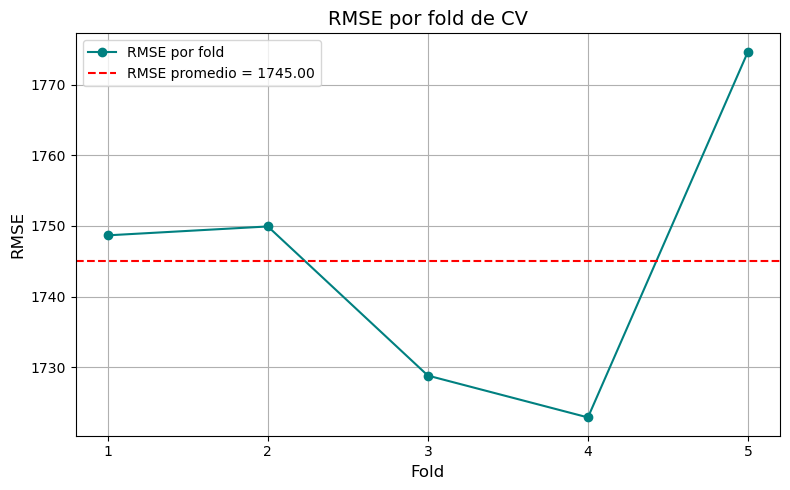

In [25]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# Evaluar RMSE por fold
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
rmse_cv = np.sqrt(-scores)

# Gráfico de RMSE y CV
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(rmse_cv) + 1), rmse_cv, marker='o', linestyle='-', color='teal', label='RMSE por fold')
plt.axhline(y=rmse_cv.mean(), color='red', linestyle='--', label=f'RMSE promedio = {rmse_cv.mean():.2f}')
plt.title('RMSE por fold de CV', fontsize=14)
plt.xlabel('Fold', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.xticks(range(1, len(rmse_cv) + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
# Evaluación del modelo con validación cruzada (RMSE)
scores = cross_val_score(model, X, y, cv=3, scoring='neg_mean_squared_error')
rmse_cv = (-scores)**0.5
print(f'RMSE CV promedio: {rmse_cv.mean():.4f}')
print(f'Desviación estándar: {rmse_cv.std(ddof=1):.4f}')

rmse_cv = (-cross_val_score(model, X, y, cv=3, scoring='neg_mean_squared_error'))**0.5
pd.Series(rmse_cv).describe()

RMSE CV promedio: 1751.0385
Desviación estándar: 5.1568


count       3.000000
mean     1751.038516
std         5.156836
min      1745.815731
25%      1748.494388
50%      1751.173045
75%      1753.649908
max      1756.126771
dtype: float64

In [27]:
# Evaluación del modelo con validación cruzada (R2)
r2_cv = cross_val_score(model, X, y, cv=3, scoring='r2')
print(f'R2 CV promedio: {r2_cv.mean():.4f}')
print(f'Desviación estándar: {r2_cv.std(ddof=1):.4f}')
pd.Series(r2_cv).describe()

R2 CV promedio: 0.8007
Desviación estándar: 0.0023


count    3.000000
mean     0.800664
std      0.002304
min      0.799094
25%      0.799342
50%      0.799590
75%      0.801450
max      0.803309
dtype: float64

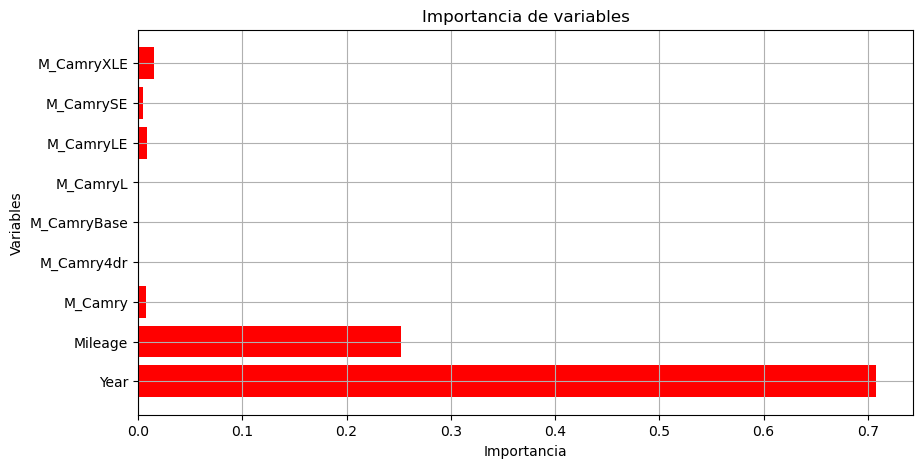

In [28]:
# Gráfica de importancia de variables
plt.figure(figsize=(10, 5))
plt.barh(X.columns, model.feature_importances_, color='red')
plt.title('Importancia de variables')
plt.xlabel('Importancia')
plt.ylabel('Variables')
plt.grid()
plt.show()

## Resumen procedimiento
1) Entrenamiento inicial del modelo:
Se entrenó el modelo de RF para regresión usando sklearn con 100 árboles y parámetros por defecto (antes habiendo elegido la variable 'y' y las variables predictoras en 'X' y el split en traing y test usando test_size = 0.33).

2) Evaluación del desempeño:
Se evaluó el RF en el conjunto test utilizando métricas como RMSE, R² y R² ajustado.

3) Validación cruzada del modelo:
Se realizó un gráfico de RMSE vs CV para obtener el fold que optimizaba el RMSE y se escogió 3 porque era el # que minimizaba esta métrica.
Posterior a eso se realizaron los cálculos de las métricas con describe de RMSE y R² para CV con el fold óptimo para revisar su distribución promedio, std, min, max y por cuartiles.
4) Gráfico de importancia de variables:
Finalmente se realizó el gráfico de importancia de variables a partir de los resultados del modelo RF generado.

## Análisis e interpretación de resultados
1) Evaluación conjunto de test de métricas:
- RMSE: En promedio, el modelo se equivoca en aproximadamente $1765 unidades al predecir el precio del auto.
- R²: El modelo explica aproximadamente el 79.6% de la variabilidad del precio de los autos. En general, indica que las características seleccionadas (marca, año, millaje, etc.) tienen fuerte capacidad explicativa y predicitiva sobre el precio.
- R² ajustado: Da alrededor de 79.5% que, en general, da muy similar al R². Lo cual es positivo porque indica que no hay posible sobreajuste por muchas variables irrelevantes.

2) CV (k=3 folds):
- RMSE (CV): En promedio, el modelo se equivoca en aproximadamente $1751 unidades al predecir el precio del auto. En comparación con el valor de RMSE en test, en general, este valor refuerza que el modelo generaliza bien a distintos subcojuntos del dataset. La desviación estándar es relativamente baja (5.15) indicando estabilidad en el modelo y consistencia puesto que su desempeño no varía mucho entre folds.
- R² (CV): El modelo, en promedio, mantiene buen poder explicativo de 80% en todos los folds. La desviación estándar es insignificante (0.0023) lo que respalda robustez del modelo.

3) Importancia de las variables:
- Year (0.71): La variable más relevante según los resultados del modelo. En promedio, el año del vehiculo captura directamente su depreciación, que es uno de lo factores más influyentes en el precio.
- Mileage (0.26): La segunda más relevante según resultados del modelo. En promedio, un mayor kilometraje podría indica mayor desgaste del vehículo, lo cual reduce su precio.
- M_Camry (en general menos de 0.05 cada una): Estas variables dummies indican el modelo exacto del Toyota Camry. Su baja importancia individual sugiere que, en promedio aunque el modelo del auto tiene cierto efecto en el precio, es muy inferior comparado con el año y millaje.

## Conclusiones:
1) El modelo RF predice con buena precisión el precio de autos usados, con errores promedio de $1750 y un alto grado de explicación de la variabilidad del precio (80%).

2) La consistencia entre training, test y CV indican que el modelo no está sobreajustado y es confiable.

3) En general, el precio de los autos está explicado principalmente por qué tan nuevo es (Year) y el millaje recorrido (Mileage). Y, por otro lado, los modelos específicos del Camry tienen un peso muy pequeño en la predicción del precio.cción del precio.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [29]:
# Celda 5
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

# Definir el modelo base
rf = RandomForestRegressor(random_state=1, n_jobs=-1)

# Definir el grid de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 5, 10, 20]
}

# Definir GridSearch con 3-fold CV y scoring por RMSE
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# Ajustar el modelo
grid_search.fit(X_train, y_train)

# Extraer el mejor modelo y sus hiperparámetros
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluar el mejor modelo con RMSE
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mejores hiperparámetros: {best_params}')
print(f'RMSE - mejor modelo: {rmse:.2f}')
print(f'R2 - mejor modelo: {best_model.score(X_test, y_test):.4f}')
print(f'R2 ajustado - mejor modelo: {1 - (1-best_model.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1):.4f}')

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Mejores hiperparámetros: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
RMSE - mejor modelo: 1564.57
R2 - mejor modelo: 0.8400
R2 ajustado - mejor modelo: 0.8396


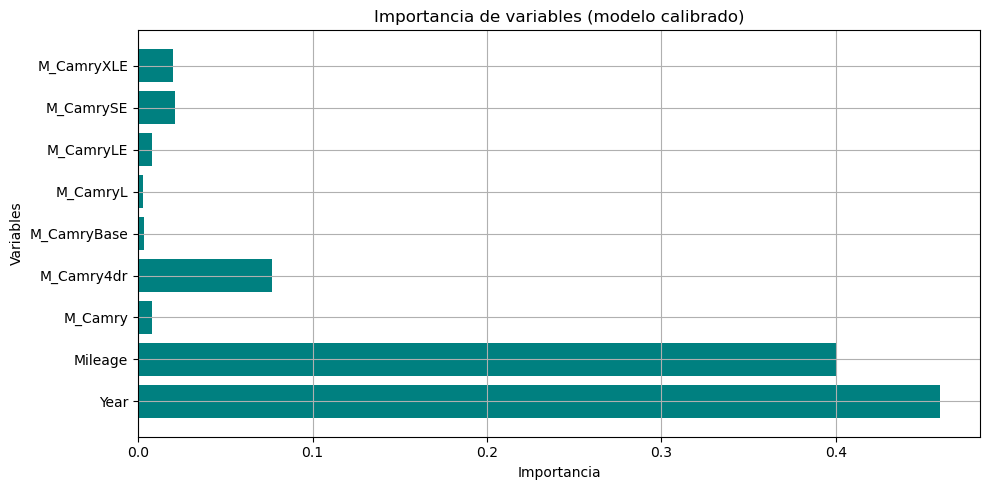

In [30]:
# Gráfica de importancia de variables usando el mejor modelo del GridSearch
import matplotlib.pyplot as plt

importancias = best_model.feature_importances_

plt.figure(figsize=(10, 5))
plt.barh(X_train.columns, importancias, color='teal')
plt.title('Importancia de variables (modelo calibrado)')
plt.xlabel('Importancia')
plt.ylabel('Variables')
plt.grid(True)
plt.tight_layout()
plt.show()

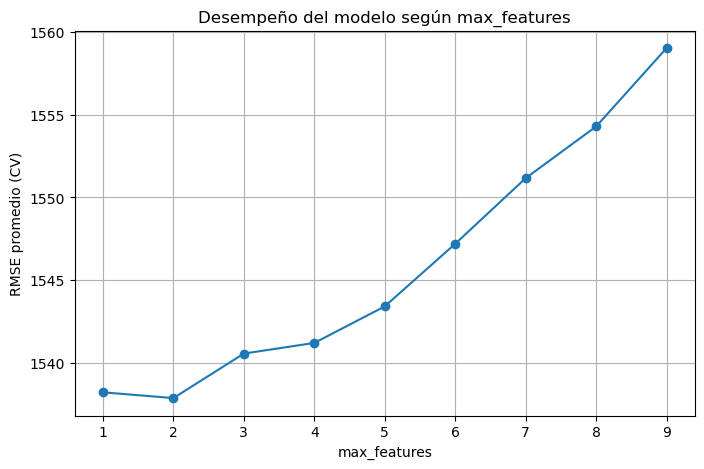

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# Definir los valores de max_features a evaluar
max_features_range = range(1, X_train.shape[1] + 1)

# Lista para guardar los RMSE promedio de cada valor
rmse_scores = []

for max_feat in max_features_range:
    model = RandomForestRegressor(n_estimators=200, max_features=max_feat, max_depth=10, random_state=42, n_jobs=-1)
    neg_mse = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-neg_mse.mean())
    rmse_scores.append(rmse)

# Graficar RMSE promedio vs max_features
plt.figure(figsize=(8, 5))
plt.plot(max_features_range, rmse_scores, marker='o')
plt.xlabel('max_features')
plt.ylabel('RMSE promedio (CV)')
plt.title('Desempeño del modelo según max_features')
plt.grid(True)
plt.show()

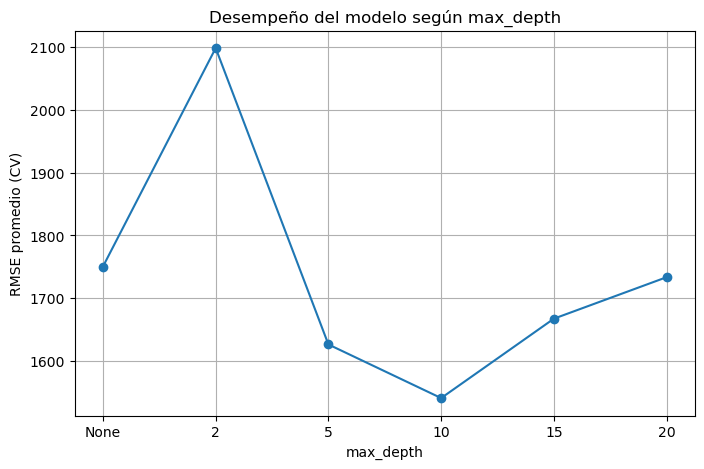

In [32]:
# Evaluar diferentes valores de max_depth
max_depth_range = [None, 2, 5, 10, 15, 20]
rmse_scores_depth = []

for depth in max_depth_range:
    model = RandomForestRegressor(n_estimators=200, max_features='sqrt', max_depth=depth, random_state=42, n_jobs=-1)
    neg_mse = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-neg_mse.mean())
    rmse_scores_depth.append(rmse)

# Gráfico de RMSE promedio vs max_depth
plt.figure(figsize=(8, 5))
labels = ['None' if d is None else str(d) for d in max_depth_range]
plt.plot(labels, rmse_scores_depth, marker='o')
plt.xlabel('max_depth')
plt.ylabel('RMSE promedio (CV)')
plt.title('Desempeño del modelo según max_depth')
plt.grid(True)
plt.show()

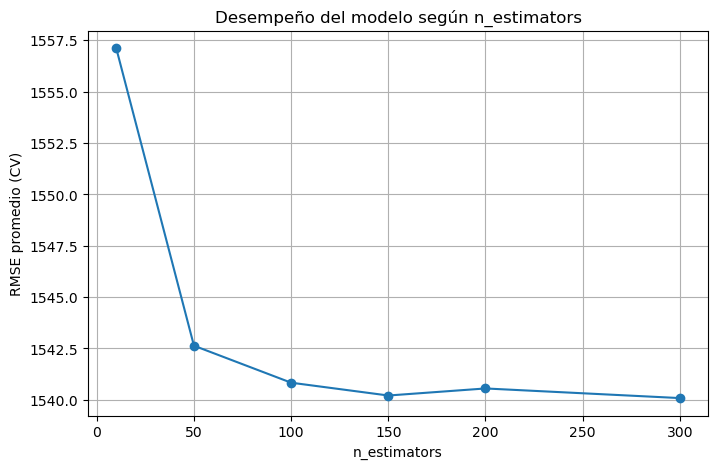

In [33]:
# Evaluar diferentes valores de n_estimators
n_estimators_range = [10, 50, 100, 150, 200, 300]
rmse_scores_estimators = []

for n in n_estimators_range:
    model = RandomForestRegressor(n_estimators=n, max_features='sqrt', max_depth=10, random_state=42, n_jobs=-1)
    neg_mse = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-neg_mse.mean())
    rmse_scores_estimators.append(rmse)

# Gráfico
plt.figure(figsize=(8, 5))
plt.plot(n_estimators_range, rmse_scores_estimators, marker='o')
plt.xlabel('n_estimators')
plt.ylabel('RMSE promedio (CV)')
plt.title('Desempeño del modelo según n_estimators')
plt.grid(True)
plt.show()

## Resumen procedimiento
1) Calibración del modelo con GridSearchCV:
Se definió un modelo base RF para regresión, y se realizó el ajuste de hiperparámetros (n_estimators, max_features y max_depth) usando GridSearchCV con CV de k= 3 folds y la métrica de evaluación RMSE como parámetro de calibración. Posterior se seleccionó el mejor modelo a partir de la combinación óptima de estos hiperparámetros.
2) Test del modelo ajustado/calibrado:
Se evaluó el desempeño del modelo seleccionado sobre el cojunto de test (X_test, y_test) usando RMSE, R² y R² ajustado como métricas principales. Esto permitió validar si la calibración mejoró la capacidad predicitiva del modelo.
3) Análisis del efecto de hiperparámetros individuales (análisis ceteris paribus):
Se exploró el impacto individual de cada hiperparámetro de calibración (n_estimators, max_features y max_depth) sobre el RMSE promedio usando CV de 3 folds. Se graficaron las curvas individuales correspondientes para visualizar las tendencias y detectar posibles valores óptimos y/o justificar los valores óptimos según GridSearchCV manteniendo el análisis sobre las otras métricas constantes.
4) Gráfico de importancia de variables:
Finalmente, se generó un gráfico de barplot con la importancia relativa de las variables predictoras según el mejor modelo calibrado, lo que permitió identificar qué variables aportan más al modelo predictivo y si esta importancia cambiaba vs el modelo anterior (RF sin calibración de hiperparámetros).

## Análisis e interpretación de resultados
1) Modelo final calibrado:
Con los mejores hiperparámetros seleccionados (max_depth = 10, max_features = sqrt, n_estimators = 200), se entrenó un nuevo modelo, el cual fue evaluado con las métricas clave.
- RMSE = $1564.57, indicando el error promedio en la predicción del precio de carros. Siendo este mucho menor que el de RF sin calibración ($1765).
- R² = 0.8400, lo que implica que el modelo explica el 84% de la variabilidad en el precio de los autos. Este valor también es mucho mejor que el que resultó del RF sin calibración (79-80%).
- R² ajustado = 0.8396, lo cual confirma que el modelo mantiene una buena capacidad explicativa incluso ajustando y/o calibrando hiperparámetros. Este caso también, en general, muestra mejores resultados que el modelo RF sin calibración (79.5%).

2) Análisis ceteris paribus de los cambios en el desempeño del modelo basado en la calibración de cada hiperparámetro:
En este caso, se decidió primero realizar la calibración de mejores hiperparámetros según GridSearchCv y sobre estos mejores hiperparámetros se realizó el análisis individual de cada uno para mostrar su justificación según el algoritmo y su efecto individual en el desempeño del modelo según el RMSE.
Los resultados mostraron:
- **max_features:** El RMSE promedio más bajo se obtuvo con valores bajos (2,3) especialmente en sqrt (la raiz cuadrada del # total de variables que es 9, es decir la raiz cuadrada es 3). Esto sugiere que usar pocas variables aleatorias por cada árbol mejora el rendimiento, a medida que el número de variables aleatorias aumenta, el rendimiento o desempeño del modelo empeora. Esto puede estar apoyado adicionalmente con el análisis gráfico de importancia de variables, del cual se desprende que pocas variables realmente tienen una buena capacidad predictiva y de desempeño sobre la variable de predicción de precios de los autos.
- **max_depth:** Se evidenció un mejor desempeño con profundidad de 10, lo que permite capturas relaciones no lineales sin asobreajustar, este valor se justifica también según lo hallado con GridSearchCV así como con el valor óptimo en max_features. Profundidades menores (como 2) mostraron un RMSE considerablemente peor, mientras que profundidades muy grandes (15,20) incrementaron el error.
- **n_estimators:** A partir de 150 árboles y hasta 200 árboles, el RMSE se estabiliza, indicando que más árboles no necesariamente mejoran el desempeño, pero ayudan a estabilizarlo hasta cierto punto. La elección de este hiperparámetro también debe ser computacionalmente menos costoso y más estratégico. El resultado gráfico también justifica la elección con GridSearchCV.

3) Importancia de variables:
Las variables más relevantes fueron Year y Mileage, lo que tiene sentido dado que son atributos clave en la determinación del precio de un auto. Nuevamente las variables dummy asociadas a los modelos (M_Camry) aportan información pero con mucho menor peso individual. En comparación con la importancia de las variables en el modelo RF sin calibración se puede evidenciar cómo Mileage aumentó su importancia y también significativamente M_Camry4dr en este caso con el RF calibrado a mejores hiperparámetros.

## Conclusiones
- El modelo RF tras calibración alcanzó un mejor desempeño predictivo (comparado con el RF sin calibrar) bajo todas las métricas de interés, explicando un alto porcentaje de la variabilidad de la variable predicción con un error relativamente bajo.
- La selección de hiperparámetros fue clavse para optimizar el modelo. Se observó que configuraciones con profundidad media, selección limitada de variables por split (sqrt) y el # de árboles moderado ofrecieron el mejor rendimiento según el análisis gráfico y el algortimo de GridSearchCV.
- El análisis de importancia de variables permitió identificar que el año del modelo y el kilometraje del vehículo son los factores más determinantes en la predicción.
- Finalmente, el modelo calibrado ofrece una base sólida y optimizada para integraciones en sistemas de recomendación de pricing automático de carros.


### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [34]:
# Celda 6
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

modeloXGB = XGBRegressor(random_state=42)

modeloXGB.fit(X_train, y_train)
y_pred = modeloXGB.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
print(f'RMSE: {rmse}')

r2 = modeloXGB.score(X_test, y_test)
print(f'R2: {r2}')

r2_adjusted = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print(f'R2 ajustado: {r2_adjusted}')


RMSE: 1605.2354967418332
R2: 0.8315404653549194
R2 ajustado: 0.831101514627703


In [35]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(modeloXGB, X, y, cv=10, scoring='neg_mean_squared_error')
rmse_cv = (-scores)**0.5

print(f'RMSE CV promedio: {rmse_cv.mean():.4f}')
print(f'Desviación estándar: {rmse_cv.std(ddof=1):.4f}')

rmse_cv = (-cross_val_score(modeloXGB, X, y, cv=10, scoring='neg_mean_squared_error'))**0.5
pd.Series(rmse_cv).describe()


RMSE CV promedio: 1568.8838
Desviación estándar: 59.5904


count      10.000000
mean     1568.883764
std        59.590365
min      1493.884868
25%      1527.608906
50%      1566.149777
75%      1595.090245
max      1695.208837
dtype: float64

In [36]:
r2_cv = cross_val_score(modeloXGB, X, y, cv=10, scoring='r2')
print(f'R2 CV promedio: {r2_cv.mean():.4f}')
print(f'Desviación estándar: {r2_cv.std(ddof=1):.4f}')
pd.Series(r2_cv).describe()

R2 CV promedio: 0.8396
Desviación estándar: 0.0107


count    10.000000
mean      0.839630
std       0.010674
min       0.826053
25%       0.832218
50%       0.840986
75%       0.843708
max       0.855974
dtype: float64

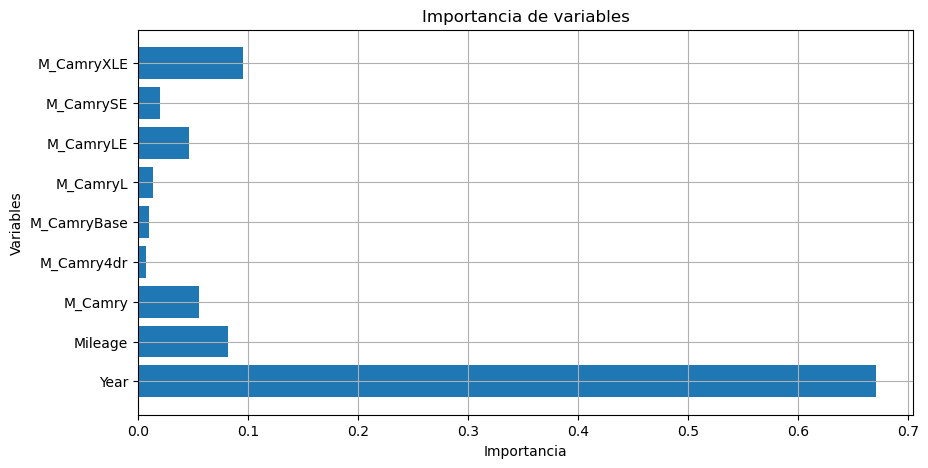

In [37]:
plt.figure(figsize=(10, 5))
plt.barh(X.columns, modeloXGB.feature_importances_)
plt.title('Importancia de variables')
plt.xlabel('Importancia')
plt.ylabel('Variables')
plt.grid()
plt.show()

Análisis e interpretación de resultados

1) Evaluación conjunto de test de métricas:
* RMSE: Evidenciamos que con la implementación del modelo de XGBoost el error en la predicción disminuyo  a $1605 unidades al predecir el precio del auto.
* R2 y R2 ajustado: El modelo explica aproximadamente el 83.1% de la variabilidad del precio de los autos, el cual aumenta en comparación con random forest, indicando que se logra explicar una mayor proporción de la variabilidad del precio de los automóviles.


2) Evauación implementando cross validation:

* RMSE (CV): Para la implementación de cv tomamos un fold de 10 y evidenciamos que implementando cross validation el error de predicción disminuyo mucho más, pues el modelo se equivoca en aproximadamente $1568 unidades al predecir el precio del auto. Sin embargo, la desviación estándar comparada con la de random forest aumento indicando que algunos fold predicen mejor que otros.
* R² (CV): el R2 para el modelo aumentó acercandose al 84% y aumentando casi 4% en comparación con el modelo de random forest. La desviación estándar es al igual que la del error aumento con random por el número de folds usados.

3) Importancia de las variables:

Year sigue siendo la variable mas importante en el modelo, con una importancia de 0.68, y la segunda variable más relevante sigue siendo Mileage. A diferencia con el modelo de random forest, XGBoost le asigna mayorimportancia a otras variables relacionadas, lo cual sugiere que este modelo logra capturar relaciones más sutiles entre las características y el precio.

**Conclusiones:**

El modelo XGBoost demostró un excelente desempeño. Inicialmente, en la evaluación train/test, alcanzó un RMSE de 1605 y un R² de 0.8315, lo que indica que logra explicar aproximadamente el 83% de la variabilidad de los precios.
Posteriormente, mediante validación cruzada de 10 folds, pudimos evidenciar su solides obteniendo un RMSE promedio de 1568 y un R² promedio de 0.8396.En conclusión se evidencia que XGBoost se posiciona como un modelo altamente eficaz para este problema destacándose por su capacidad predictiva.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [38]:
# Celda 7
from sklearn.model_selection import GridSearchCV

xgb = XGBRegressor(random_state=1, n_jobs=-1)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'gamma': [0, 0.1, 0.3, 0.5],
    'colsample_bytree': [0.3, 0.5, 0.7, 1]
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=10,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

mejor_modelo = grid_search.best_estimator_
mejor_parms = grid_search.best_params_

y_pred = mejor_modelo.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mejores hiperparámetros: {mejor_parms}')
print(f'RMSE - mejor modelo: {rmse:.2f}')
print(f'R2 - mejor modelo: {mejor_modelo.score(X_test, y_test):.4f}')
print(f'R2 ajustado - mejor modelo: {1 - (1-mejor_modelo.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1):.4f}')


Fitting 10 folds for each of 64 candidates, totalling 640 fits
Mejores hiperparámetros: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.05}
RMSE - mejor modelo: 1547.30
R2 - mejor modelo: 0.8435
R2 ajustado - mejor modelo: 0.8431


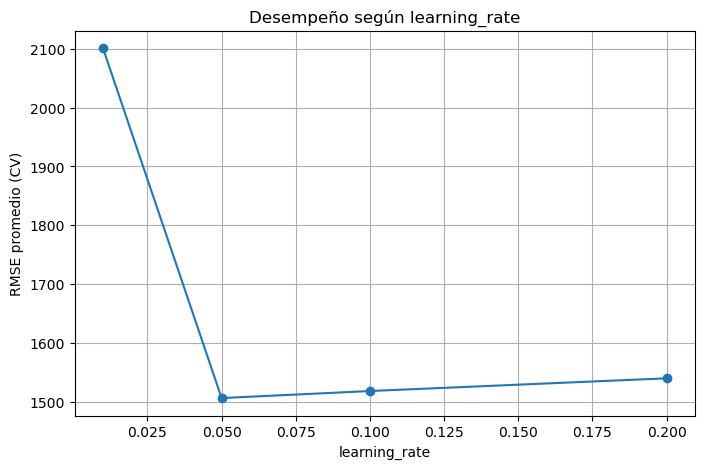

In [39]:
learning_rate_range = [0.01, 0.05, 0.1, 0.2]
rmse_scores_lr = []  # Lista para RMSE de cada learning_rate

for lr in learning_rate_range:
    model = XGBRegressor(learning_rate=lr, gamma=0, colsample_bytree=0.7, random_state=42)
    neg_mse = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-neg_mse.mean())
    rmse_scores_lr.append(rmse)  # Aquí corregido

plt.figure(figsize=(8,5))
plt.plot(learning_rate_range, rmse_scores_lr, marker='o')
plt.xlabel('learning_rate')
plt.ylabel('RMSE promedio (CV)')
plt.title('Desempeño según learning_rate')
plt.grid(True)
plt.show()

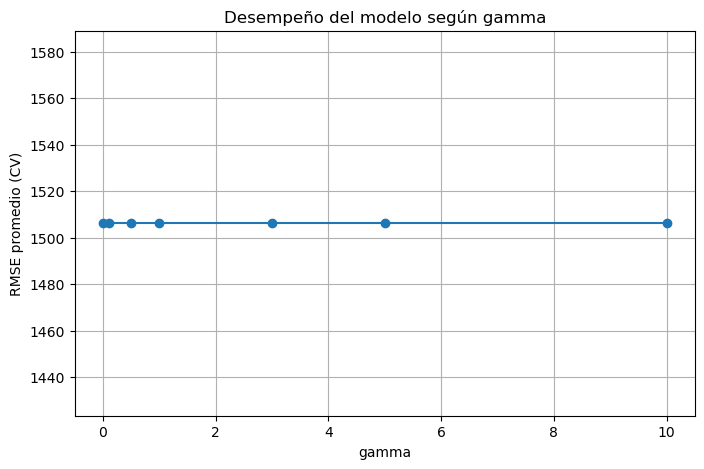

In [ ]:
gamma_range = [0, 0.1, 0.3, 0.5]
rmse_scores_gamma = []

for gamma_val in gamma_range:
    model = XGBRegressor(learning_rate=0.05, gamma=gamma_val, colsample_bytree=0.7, random_state=42)
    neg_mse = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-neg_mse.mean())
    rmse_scores_gamma.append(rmse)

# Graficar RMSE promedio vs gamma
plt.figure(figsize=(8,5))
plt.plot(gamma_range, rmse_scores_gamma, marker='o')
plt.xlabel('gamma')
plt.ylabel('RMSE promedio (CV)')
plt.title('Desempeño del modelo según gamma')
plt.grid(True)
plt.show()

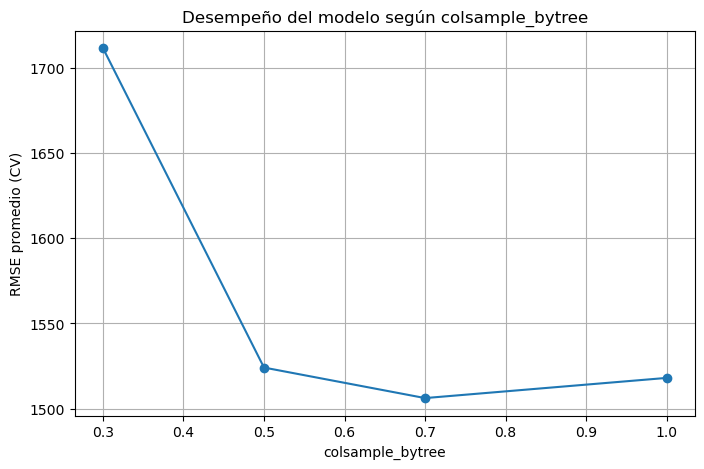

In [41]:
colsample_range = [0.3, 0.5, 0.7, 1]
rmse_scores = []

for colsample in colsample_range:
    model = XGBRegressor(learning_rate=0.05, gamma=0, colsample_bytree=colsample,random_state=42)
    neg_mse = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-neg_mse.mean())
    rmse_scores.append(rmse)

plt.figure(figsize=(8,5))
plt.plot(colsample_range, rmse_scores, marker='o')
plt.xlabel('colsample_bytree')
plt.ylabel('RMSE promedio (CV)')
plt.title('Desempeño del modelo según colsample_bytree')
plt.grid(True)
plt.show()


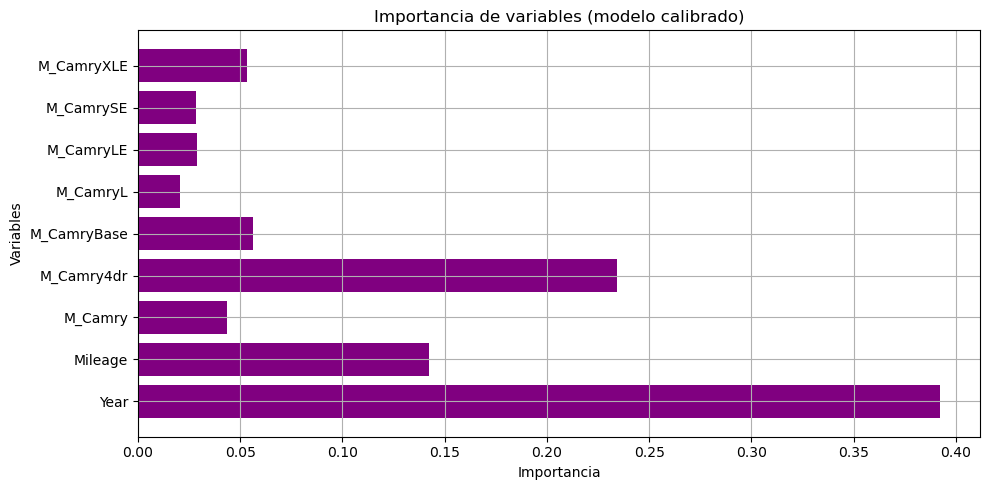

In [42]:
importancias = mejor_modelo.feature_importances_

plt.figure(figsize=(10, 5))
plt.barh(X_train.columns, importancias, color='purple')
plt.title('Importancia de variables (modelo calibrado)')
plt.xlabel('Importancia')
plt.ylabel('Variables')
plt.grid(True)
plt.tight_layout()
plt.show()

Análisis e interpretación de resultados

1) Evaluación conjunto de test con GridSearchCV :
Se realizó una calibración de los hiperparámetros learning_rate, gamma y colsample_bytree mediante GridSearchCV con validación cruzada de 10 folds. El mejor modelo encontró una combinación que minimizó el error, obteniendo un RMSE de 1549, un R² y R² ajustado de 84%.

Comparado con los resultados del modelo de XGBoost sin calibrar, el ajuste de estos hiperparámetros permitió mejorar el desempeño del modelo, lo cual ayudó a evitar el sobreajuste y a capturar mejor las relaciones en los datos.

2) Evaluación individual de las calibraciones:

Igual que con el modelo de random forest se decidio realizar la calibración de los mejores hiperparámetros utilizando GridSearchCV, y sobre estos mejores hiperparámetros se realizó un análisis individual de cada uno ceteris paribus para mostrar su justificación técnica y su efecto en el desempeño del modelo medido a través del RMSE.

* learning_rate: El RMSE promedio más bajo se obtuvo con un learning_rate de 0.05. Se observó que un learning_rate muy bajo como 0.01 genera un RMSE considerablemente alto, indicando que el modelo no logra aprender de manera efectiva debido a un avance demasiado lento. A medida que el learning_rate aumenta hacia 0.05, el RMSE disminuye drásticamente, alcanzando su mejor valor. Pero al incrementar el learning_rate a 0.1 y 0.2, el error vuelve a incrementarse levemente, por lo que justifica tomar ese valor de learning_rate según el análisis gráfico y los resultados de GridSearchCV.

* gamma: Para el parámetro gamma se encontró que variaciones de gamma entre 0 y 0.5 no generaron cambios significativos en el RMSE. La curva de desempeño fue prácticamente plana, lo que indica que controlar la complejidad de los árboles mediante gamma no mejora ni deteriora el modelo. Por tanto, se justifica mantener el valor de gamma en 0, como fue determinado en la calibración inicial.

* colsample_bytree: Y para el parámetro colsample_bytree se encontró que valores bajos generaban un RMSE elevado, al aumentar colsample_bytree a 0.5 y especialmente a 0.7, el RMSE disminuyó, alcanzando su mejor desempeño en 0.7. Usar todas las variables. Sin embargo al establecer un colsample_bytree=1 volvió a incrementar ligeramente el error, sugiriendo un posible sobreajuste. Por lo que la elección de 0.7 representa un equilibrio soportado por el análisis gráfico y la calibración de resultados de GridSearchCV.

3) Importancia de las variables:

El modelo calibrado confirma que el año del vehículo y el kilometraje siguen siendo las variables mas importantes en la predicción del precio, pero ahora también se evidencia una mayor importancia de la variable M_Camry4rd, lo que sugiere que el modelo calibrado es capaz de capturar mejor la complejidad de los datos.

**Conclusiones:**

Tras la calibración de los hiperparámetros learning_rate, gamma y colsample_bytree mediante GridSearchCV, el modelo XGBoost logró mejorar significativamente su desempeño, alcanzando un RMSE de 1549 y un R² ajustado de 84%, superior al modelo no calibrado. El análisis ceteris paribus mostró que un learning_rate de 0.05 optimizó la capacidad de aprendizaje, que gamma no tuvo un impacto relevante sobre el error, y que un colsample_bytree de 0.7 dio el mejor balance entre diversidad y precisión. Además, el modelo calibrado establecio nuevamente la importancia principal de las variables Year y Mileage en la predicción de precios, incorporando también de forma más efectiva características específicas como M_Camry4dr.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

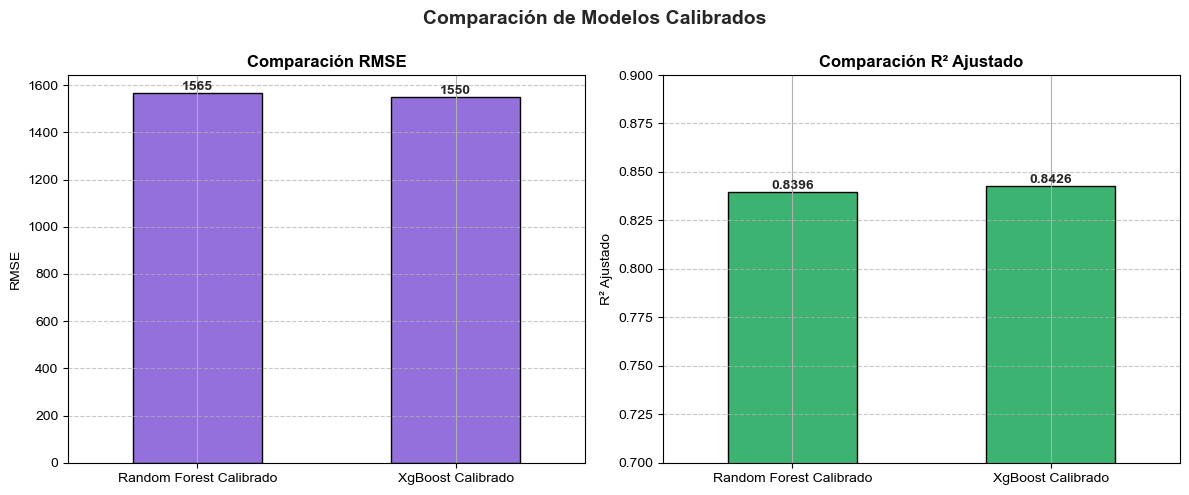

                            RMSE  R² ajustado
Random Forest Calibrado  1564.57       0.8396
XgBoost Calibrado        1549.53       0.8426


In [43]:
# Celda 8
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Resultados
resultados = {
    'Random Forest Calibrado': {'RMSE': 1564.57, 'R² ajustado': 0.8396},
    'XgBoost Calibrado': {'RMSE': 1549.53, 'R² ajustado': 0.8426}
}

df_resultados = pd.DataFrame(resultados).T

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.set_style("whitegrid")

# RMSE
ax_rmse = df_resultados['RMSE'].plot(kind='bar', ax=axes[0], color='#9370DB', edgecolor='black')
axes[0].set_title('Comparación RMSE', fontsize=12, fontweight='bold')
axes[0].set_ylabel('RMSE')
axes[0].set_xlabel('')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].tick_params(axis='x', rotation=0)

# Etiquetas RMSE
for p in ax_rmse.patches:
    height = p.get_height()
    ax_rmse.annotate(f'{height:.0f}',
                     (p.get_x() + p.get_width() / 2, height),
                     ha='center', va='bottom', fontsize=10, fontweight='bold')

# R² ajustado
ax_r2 = df_resultados['R² ajustado'].plot(kind='bar', ax=axes[1], color='#3CB371', edgecolor='black')
axes[1].set_title('Comparación R² Ajustado', fontsize=12, fontweight='bold')
axes[1].set_ylabel('R² Ajustado')
axes[1].set_xlabel('')
axes[1].set_ylim(0.7, 0.9)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].tick_params(axis='x', rotation=0)

# Etiquetas R² ajustado
for p in ax_r2.patches:
    height = p.get_height()
    ax_r2.annotate(f'{height:}',
                   (p.get_x() + p.get_width() / 2, height),
                   ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('Comparación de Modelos Calibrados', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

print(df_resultados)

Al comparar los resultados obtenidos de los modelos calibrados de Random Forest y XGBoost, se observa que XGBoost calibrado logró un desempeño superior. El modelo de XGBoost obtuvo un RMSE de 1549.53 y un R² ajustado de 0.8426, mientras que el modelo de Random Forest calibrado alcanzó un RMSE de 1564.57 y un R² ajustado de 0.8396.

Entre las ventajas principales de XGBoost se destaca su capacidad de optimizar el error de manera más eficiente mediante técnicas como el gradiente descendente y la penalización regularizada. Esto se refleja en su mejor desempeño tanto en precisión como en estabilidad del error. Además, la calibración de hiperparámetros permitió ajustar aspectos como la tasa de aprendizaje y el muestreo de columnas, mejorando aún más el modelo.

Por otro lado, aunque el random forest calibrado mostró también un buen desempeño sus predicciones no fueron tan precisas. Aunque tiene un rendimiento competitivo y estima el error fuera de la muestra sin utilizar la división de entrenamiento y prueba, entre sus desventajas se encuentran una menor eficiencia computacional, una mayor complejidad de interpretación y la falta de mecanismos de regularización frente al sobreajuste, en comparación con XGBoost.

En conclusión, XGBoost fue el mejor modelo, mientras que Random Forest, aunque competitivo, presentó un desempeño ligeramente inferior.